In [1]:
!pip install transformers torchaudio datasets scikit-learn pandas tqdm librosa

import os
import torch
import numpy as np
import random

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
import os
import subprocess
import glob
from tqdm import tqdm

#Setting up routes
DATA_ROOT = "./data"
TAR_FILE = os.path.join(DATA_ROOT, "MELD.Raw.tar.gz")
EXTRACT_PATH = os.path.join(DATA_ROOT, "MELD_Raw")
AUDIO_OUTPUT_DIR = os.path.join(DATA_ROOT, "audio_folder")
MELD_URL = "https://web.eecs.umich.edu/~mihalcea/downloads/MELD.Raw.tar.gz"

# making folders
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(AUDIO_OUTPUT_DIR, exist_ok=True)

print(" Step 1: Checking Data File...")

# download file(if not exist)
if not os.path.exists(TAR_FILE):
    print(f"File not found. Downloading from {MELD_URL}...")
    print("This is a large file (~10GB), please be patient...")
    # Using wget with resume (-c) capability and ignoring certificate in case of SSL error
    !wget -c --no-check-certificate {MELD_URL} -O {TAR_FILE}
else:
    print(f" File found! Size: {os.path.getsize(TAR_FILE) / (1024**3):.2f} GB")

# Extract the file (if the extracted folder is empty)
print("\n Step 2: Extracting Data...")
# Check if it hasn't been extracted before
if not os.path.exists(EXTRACT_PATH) or len(os.listdir(EXTRACT_PATH)) == 0:
    os.makedirs(EXTRACT_PATH, exist_ok=True)
    print("Extracting tar.gz file (this takes a few minutes)...")
    try:
        !tar -xzf {TAR_FILE} -C {EXTRACT_PATH}
        print(" Extraction Complete.")
    except Exception as e:
        print(f" Extraction Failed: {e}")
        # If the file was downloaded corruptly, we delete it so that it can be downloaded correctly next time
        # os.remove(TAR_FILE)
else:
    print(" Files already extracted.")

#  Find and convert files
print("\n Step 3: Processing Audio...")

# Find all mp4 files in all subfolders
mp4_files = []
for root, dirs, files in os.walk(EXTRACT_PATH):
    for file in files:
        if file.endswith(".mp4"):
            mp4_files.append(os.path.join(root, file))

print(f"Found {len(mp4_files)} video files to process.")

if len(mp4_files) == 0:
    print(" CRITICAL ERROR: No MP4 files found after extraction.")
    print("Please delete './data' folder and restart ensuring reliable internet.")
else:
    # conert to wav
    converted_count = 0
    already_exists_count = 0

    print("Converting MP4 to WAV (16kHz)...")
    for mp4_path in tqdm(mp4_files):
        filename = os.path.basename(mp4_path)
        wav_filename = filename.replace(".mp4", ".wav")
        wav_path = os.path.join(AUDIO_OUTPUT_DIR, wav_filename)

        if not os.path.exists(wav_path):
            try:
                # Fast and silent conversion with ffmpeg
                subprocess.call([
                    "ffmpeg", "-i", mp4_path,
                    "-ar", "16000",
                    "-ac", "1",
                    "-vn", # Delete image
                    "-loglevel", "error",
                    "-y", # overwrite
                    wav_path
                ])
                converted_count += 1
            except Exception as e:
                pass
        else:
            already_exists_count += 1

    print("\n" + "="*40)
    print(" DATA PREPARATION FINISHED")
    print("="*40)
    print(f"Total MP4 files found: {len(mp4_files)}")
    print(f"Newly converted: {converted_count}")
    print(f"Already existed: {already_exists_count}")

    total_wavs = len(os.listdir(AUDIO_OUTPUT_DIR))
    print(f"Total WAV files ready in '{AUDIO_OUTPUT_DIR}': {total_wavs}")

    if total_wavs > 1000:
        print(" Success! You can now run the Training Cell.")
    else:
        print(" Warning: Seems like very few audio files were processed.")

 Step 1: Checking Data File...
File not found. Downloading from https://web.eecs.umich.edu/~mihalcea/downloads/MELD.Raw.tar.gz...
This is a large file (~10GB), please be patient...
--2026-02-13 10:05:14--  https://web.eecs.umich.edu/~mihalcea/downloads/MELD.Raw.tar.gz
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 10878146150 (10G) [application/x-gzip]
Saving to: ‘./data/MELD.Raw.tar.gz’

./data/MELD.Raw.tar 100%[===================>]  10.13G  1.27MB/s    in 76m 27s 

2026-02-13 11:21:43 (2.26 MB/s) - ‘./data/MELD.Raw.tar.gz’ saved [10878146150/10878146150]


 Step 2: Extracting Data...
Extracting tar.gz file (this takes a few minutes)...
 Extraction Complete.

 Step 3: Processing Audio...
Found 0 video files to process.
 CRITICAL ERROR: No MP4 files found after extraction

In [3]:
import os
import tarfile
import subprocess
import shutil
from tqdm import tqdm
import glob

# Paths identified in the previous step
BASE_EXTRACT_PATH = "/content/data/MELD_Raw/MELD.Raw"
AUDIO_OUTPUT_DIR = "/content/data/audio_folder"
CSV_OUTPUT_DIR = "/content/data/csv_folder"

# List of internal compressed files
inner_tars = [
    os.path.join(BASE_EXTRACT_PATH, "train.tar.gz"),
    os.path.join(BASE_EXTRACT_PATH, "dev.tar.gz"),
    os.path.join(BASE_EXTRACT_PATH, "test.tar.gz")
]

# Extract internal files (Train, Dev, Test)
print(" Phase 2: Extracting inner dataset splits...")
for tar_path in inner_tars:
    if os.path.exists(tar_path):
        print(f"  Extracting: {os.path.basename(tar_path)} ...")
        try:
            with tarfile.open(tar_path, "r") as tar:
                tar.extractall(path=BASE_EXTRACT_PATH)
            print(" Done.")
            # Optional: Delete the compressed file to free up disk space
            # os.remove(tar_path)
        except Exception as e:
            print(f" Error extracting {tar_path}: {e}")
    else:
        print(f"File not found: {tar_path}")

# Find all extracted MP4 files
print("\n Scanning for extracted MP4 videos...")
mp4_files = []
for root, dirs, files in os.walk(BASE_EXTRACT_PATH):
    for file in files:
        if file.endswith(".mp4"):
            mp4_files.append(os.path.join(root, file))

print(f" Found total {len(mp4_files)} MP4 files.")

# convert to WAV
if len(mp4_files) > 0:
    os.makedirs(AUDIO_OUTPUT_DIR, exist_ok=True)
    print("\n Converting videos to WAV (16kHz, Mono)...")
    success_count = 0
    for mp4_path in tqdm(mp4_files):
        filename = os.path.basename(mp4_path)
        # Clean up file names
        safe_filename = filename.replace(" ", "_")
        wav_path = os.path.join(AUDIO_OUTPUT_DIR, safe_filename.replace(".mp4", ".wav"))

        if not os.path.exists(wav_path):
            try:
                # ffmpeg command to extract audio
                subprocess.call([
                    "ffmpeg", "-i", mp4_path, "-ar", "16000", "-ac", "1",
                    "-vn", "-loglevel", "error", "-y", wav_path
                ])
                success_count += 1
            except Exception as e:
                print(f"Failed to convert {filename}: {e}")
        else:
            success_count += 1

    print(f"\n Audio Conversion Complete!")
    print(f" Total Audio Files: {len(os.listdir(AUDIO_OUTPUT_DIR))}")
else:
    print(" ERROR: Still no MP4 files found after extracting inner tars. Something is wrong with the extraction path.")

# 4. Moving CSV files (labels)
print("\n Organizing CSV Label files...")
os.makedirs(CSV_OUTPUT_DIR, exist_ok=True)
csv_files = glob.glob(os.path.join(BASE_EXTRACT_PATH, "*.csv"))

if csv_files:
    for csv in csv_files:
        shutil.copy(csv, CSV_OUTPUT_DIR)
        print(f"    Copied labels: {os.path.basename(csv)}")
else:
    print("No CSV files found in the extraction folder. You might need to download them separately if they are not in the tar.")

print("\n DATA PREPARATION FINISHED!")
print(f"Audio Path: {AUDIO_OUTPUT_DIR}")
print(f"CSV Path: {CSV_OUTPUT_DIR}")

 Phase 2: Extracting inner dataset splits...
  Extracting: train.tar.gz ...


/tmp/ipython-input-3235619105.py:27: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=BASE_EXTRACT_PATH)


 Done.
  Extracting: dev.tar.gz ...
 Done.
  Extracting: test.tar.gz ...
 Done.

 Scanning for extracted MP4 videos...
 Found total 15908 MP4 files.

 Converting videos to WAV (16kHz, Mono)...


100%|██████████| 15908/15908 [25:54<00:00, 10.23it/s]



 Audio Conversion Complete!
 Total Audio Files: 11264

 Organizing CSV Label files...
    Copied labels: test_sent_emo.csv
    Copied labels: dev_sent_emo.csv
    Copied labels: train_sent_emo.csv

 DATA PREPARATION FINISHED!
Audio Path: /content/data/audio_folder
CSV Path: /content/data/csv_folder


In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, Wav2Vec2Processor, Wav2Vec2Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob

# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Device set to: {device}")

# Data paths (exactly the same ones we created in the previous step)
AUDIO_PATH = "/content/data/audio_folder"
CSV_PATH = "/content/data/csv_folder"

# Mapping emotions to numbers (according to the MELD standard and your project)
EMOTION_MAP = {
    'neutral': 0,
    'surprise': 1,
    'fear': 2,
    'sadness': 3,
    'joy': 4,
    'disgust': 5,
    'anger': 6
}
# Reverse map to display results
ID_TO_EMOTION = {v: k for k, v in EMOTION_MAP.items()}

print(" Setup complete.")

 Device set to: cuda
 Setup complete.


In [ ]:
import torch
import torchaudio
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import RobertaModel, Wav2Vec2Model, RobertaTokenizer, Wav2Vec2Processor
from sklearn.metrics import classification_report, f1_score, accuracy_score
import os
import glob
from tqdm import tqdm


# 1. Search and index audio files
def index_files(search_root="/content"):
    print(f" Scanning '{search_root}' for .wav files...")
    # Recursive search to find all wav files
    audio_files = glob.glob(f"{search_root}/**/*.wav", recursive=True)

    file_map = {}
    for path in audio_files:
        # We store the filename as the key and the full path as the value
        filename = os.path.basename(path).strip()
        file_map[filename] = path

    print(f" Found {len(file_map)} audio files on disk.")
    return file_map

AUDIO_FILE_MAP = index_files(search_root="/content")

# 2. Find the path to CSV files
csv_files = glob.glob("/content/**/train_sent_emo.csv", recursive=True)
if not csv_files:
    raise FileNotFoundError("Could not find train_sent_emo.csv anywhere in /content")
CSV_ROOT = os.path.dirname(csv_files[0])
print(f" Using CSV files found in: {CSV_ROOT}")

# 3. Dataset class (modified to fix mask bug)
EMOTION_MAP = {
    'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3,
    'neutral': 4, 'sadness': 5, 'surprise': 6
}


 Scanning '/content' for .wav files...
 Found 11264 audio files on disk.
 Using CSV files found in: /content/data/csv_folder
 Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

[TRAIN] Initialized with 9989 samples.
[VAL] Initialized with 1109 samples.
✅ DataLoaders created successfully. Proceed to Training.


In [ ]:
import torch
import torchaudio
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

class MELDMultimodalDataset(Dataset):
    def __init__(self, csv_path, audio_file_map, text_tokenizer, audio_processor, split_name="data"):
        self.audio_file_map = audio_file_map
        self.text_tokenizer = text_tokenizer
        self.audio_processor = audio_processor # This processor performs automatic normalization

        # Reading CSV by handling encoding
        try:
            self.data = pd.read_csv(csv_path)
        except:
            self.data = pd.read_csv(csv_path, encoding='cp1252')

        # Clean up column names
        self.data.columns = [c.strip().replace('\ufeff', '') for c in self.data.columns]

        # Filter rows where the audio file is not available
        self.valid_data = []
        for idx, row in self.data.iterrows():
            # Create file name based on MELD format
            dia = row['Dialogue_ID']
            utt = row['Utterance_ID']
            filename = f"dia{dia}_utt{utt}.wav"

            if filename in self.audio_file_map:
                self.valid_data.append(row)

        print(f"[{split_name}] Original: {len(self.data)} -> Valid Audio Found: {len(self.valid_data)}")

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        row = self.valid_data[idx]

        #1. Text Processing
        text = str(row['Utterance']).strip()
        text_inputs = self.text_tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        #2. Sound processing
        dia = row['Dialogue_ID']
        utt = row['Utterance_ID']
        filename = f"dia{dia}_utt{utt}.wav"
        audio_path = self.audio_file_map[filename]

        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono (if it was stereo)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Convert to mono (if it was stereo)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        audio_input = waveform.squeeze().numpy()

        # The critical part: Manual normalization for safety 
        # Wav2Vec2Processor usually does this, but to be extra sure:
        if np.abs(audio_input).max() > 0:
            audio_input = audio_input / np.abs(audio_input).max()

        # Limit the audio length (e.g. 6 seconds = 96000 samples)
        MAX_AUDIO_LEN = 100000
        if len(audio_input) > MAX_AUDIO_LEN:
            audio_input = audio_input[:MAX_AUDIO_LEN]

        # Using Wav2Vec2 processor
        # Note: padding=True and return_attention_mask=True are very important
        audio_processed = self.audio_processor(
            audio_input,
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            max_length=MAX_AUDIO_LEN,
            truncation=True,
            return_attention_mask=True  #This line solves the KeyError problem
        )
        # 3. lable
        emotion = str(row['Emotion']).strip().lower()
        label = EMOTION_MAP.get(emotion, 4) # Default neutral

        return {
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'audio_values': audio_processed['input_values'].squeeze(0),
            'audio_attention_mask': audio_processed['attention_mask'].squeeze(0), # اضافه شده
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Rebuild datasets and loaders
train_dataset = MELDMultimodalDataset(
    os.path.join(CSV_ROOT, "train_sent_emo.csv"), AUDIO_FILE_MAP, text_tokenizer, audio_processor, split_name="TRAIN"
)
val_dataset = MELDMultimodalDataset(
    os.path.join(CSV_ROOT, "dev_sent_emo.csv"), AUDIO_FILE_MAP, text_tokenizer, audio_processor, split_name="VAL"
)

# Reduce the batch size so that the memory does not fill up and the gradient remains more stable
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)


[TRAIN] Original: 9989 -> Valid Audio Found: 9989
[VAL] Original: 1109 -> Valid Audio Found: 1109


In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaModel, Wav2Vec2Model, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
import numpy as np

# 1. Simplified & Stable Model
class MultimodalSentimentModel(nn.Module):
    def __init__(self, num_classes=7):
        super(MultimodalSentimentModel, self).__init__()

        # encoders
        self.text_encoder = RobertaModel.from_pretrained('roberta-base')
        self.audio_encoder = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

        # Freeze initial layers for stability
        for param in self.text_encoder.parameters():
            param.requires_grad = False
        for param in self.audio_encoder.parameters():
            param.requires_grad = False

        # Open only the last layer (Fine-tune Layer)
        for param in self.text_encoder.encoder.layer[-1].parameters():
            param.requires_grad = True
        for param in self.audio_encoder.encoder.layers[-1].parameters():
            param.requires_grad = True

        # Adjustment layers (Projection)
        self.text_proj = nn.Sequential(
            nn.Linear(768, 256),
            nn.LayerNorm(256),  # Normalize to avoid NaN
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.audio_proj = nn.Sequential(
            nn.Linear(768, 256),
            nn.LayerNorm(256),  # Normalize to avoid NaN
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Final classification
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )


    def forward(self, input_ids, attention_mask, audio_values, audio_attention_mask):
        # 1. Text
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Using CLS Token
        text_features = text_out.last_hidden_state[:, 0, :]

        # 2. Audio
        # Important: We give the audio_attention_mask to the model so that it handles the padding itself.
        audio_out = self.audio_encoder(audio_values, attention_mask=audio_attention_mask)
        hidden_states = audio_out.last_hidden_state

        # --- Simple and safe pooling strategy ---
        # Instead of complex mask calculations, we use simple averaging over the time dimension.
        # This is much more stable and prevents NaN errors.
        audio_features = torch.mean(hidden_states, dim=1)

        # 3. Projections
        text_lat = self.text_proj(text_features)
        audio_lat = self.audio_proj(audio_features)

        # 4. Fusion
        combined = torch.cat((text_lat, audio_lat), dim=1)
        logits = self.classifier(combined)

        return logits

# 2. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

model = MultimodalSentimentModel(num_classes=7).to(device)

# Use class weights if available, otherwise normal
if 'class_weights_tensor' in locals():
    print("Using Weighted Loss")
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
else:
    print("Using Standard Loss")
    criterion = nn.CrossEntropyLoss()

# Reduce Learning Rate to prevent gradient jumping
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

EPOCHS = 10
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)

# Safe Training Loop

# Reconfigure the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalSentimentModel(num_classes=7).to(device)

# Weights (to ensure weights are not NaN)
if 'class_weights_tensor' in locals():
    # Let's check if the weights are healthy.
    if torch.isnan(class_weights_tensor).any() or torch.isinf(class_weights_tensor).any():
        print("Warning: Class weights contain NaNs/Infs. Using standard loss.")
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
else:
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2) # نرخ یادگیری پایین
EPOCHS = 6

print("\n Starting Safe Training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    # Counter to see progress
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, batch in enumerate(loop):
        #1. Transferring data to the GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        audio_values = batch['audio_values'].to(device)
        audio_attention_mask = batch['audio_attention_mask'].to(device)
        labels = batch['label'].to(device)

        # 2. Check the health of the data before the model (Sanity Check)
        if torch.isnan(audio_values).any():
            print(f"Skipping Batch {batch_idx}: NaN in audio input")
            continue

        optimizer.zero_grad()

        # 3. Model execution
        # We must pass the mask so that paddings are ignored
        outputs = model(input_ids, attention_mask, audio_values, audio_attention_mask)

        loss = criterion(outputs, labels)

        #4. Loss Review
        if torch.isnan(loss):
            print(f"\n!!! NaN Loss at Batch {batch_idx} !!!")
            # For debugging, we print a batch to see what it is
            print("Audio Max:", audio_values.max().item())
            print("Audio Min:", audio_values.min().item())
            break # Emergency stop

        loss.backward()

        # Gradient clipping (prevents explosion)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(loss=loss.item())

    # If the entire IP address was NaN and jumped out
    if len(all_labels) == 0:
        print("Epoch failed completely.")
        break

    # Calculate Train Accuracy
    train_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1} Train Loss: {total_loss/len(loop):.4f} | Train Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            audio_values = batch['audio_values'].to(device)
            audio_attention_mask = batch['audio_attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, audio_values, audio_attention_mask)
            _, predicted = torch.max(outputs, 1)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f" >> Val Acc: {val_acc:.4f}")
    print("-" * 30)


Running on: cuda


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/210 [00:00<?, ?it/s]

Wav2Vec2Model LOAD REPORT from: facebook/wav2vec2-base-960h
Key               | Status     | 
------------------+------------+-
lm_head.bias      | UNEXPECTED | 
lm_head.weight    | UNEXPECTED | 
masked_spec_embed | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Using Standard Loss


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/210 [00:00<?, ?it/s]

Wav2Vec2Model LOAD REPORT from: facebook/wav2vec2-base-960h
Key               | Status     | 
------------------+------------+-
lm_head.bias      | UNEXPECTED | 
lm_head.weight    | UNEXPECTED | 
masked_spec_embed | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



 Starting Safe Training...


Epoch 1/6: 100%|██████████| 2498/2498 [16:58<00:00,  2.45it/s, loss=1.27]

Epoch 1 Train Loss: 1.4390 | Train Acc: 0.5169


 >> Val Acc: 0.5293
------------------------------


Epoch 2/6: 100%|██████████| 2498/2498 [17:21<00:00,  2.40it/s, loss=0.317]

Epoch 2 Train Loss: 1.2788 | Train Acc: 0.5775


 >> Val Acc: 0.5672
------------------------------


Epoch 3/6: 100%|██████████| 2498/2498 [17:42<00:00,  2.35it/s, loss=2.69]

Epoch 3 Train Loss: 1.2070 | Train Acc: 0.6088


 >> Val Acc: 0.6023
------------------------------


Epoch 4/6: 100%|██████████| 2498/2498 [17:42<00:00,  2.35it/s, loss=3.43]

Epoch 4 Train Loss: 1.1669 | Train Acc: 0.6277


 >> Val Acc: 0.5915
------------------------------


Epoch 5/6: 100%|██████████| 2498/2498 [17:47<00:00,  2.34it/s, loss=3.42]

Epoch 5 Train Loss: 1.1453 | Train Acc: 0.6334


 >> Val Acc: 0.6069
------------------------------


Epoch 6/6: 100%|██████████| 2498/2498 [17:41<00:00,  2.35it/s, loss=2.95]

Epoch 6 Train Loss: 1.1188 | Train Acc: 0.6421


 >> Val Acc: 0.6168
------------------------------


final evalution

Running Final Evaluation on Validation Set...


Evaluating: 100%|██████████| 278/278 [00:54<00:00,  5.14it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


Target Classes: ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger']

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     neutral     0.4419    0.3725    0.4043       153
    surprise     0.0000    0.0000    0.0000        22
        fear     0.0000    0.0000    0.0000        40
     sadness     0.5549    0.5890    0.5714       163
         joy     0.7003    0.8702    0.7761       470
     disgust     0.4615    0.2703    0.3409       111
       anger     0.5823    0.6133    0.5974       150

    accuracy                         0.6168      1109
   macro avg     0.3916    0.3879    0.3843      1109
weighted avg     0.5643    0.6168    0.5836      1109



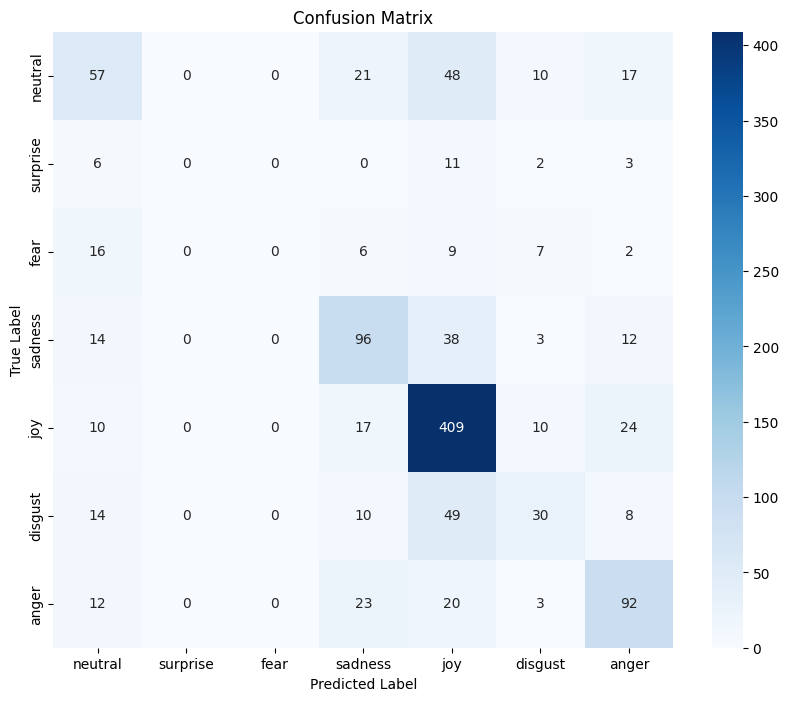


ERROR ANALYSIS HINTS
1. Diagonal elements (dark blue) show correct predictions.
2. Off-diagonal elements show errors.
   - Example: Look at the 'Neutral' row. If many samples fall into 'Sadness' column,
     it means the model confuses Neutral with Sadness.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

#1. Preparing for the Assessment
model.eval()
all_preds = []
all_labels = []

print("Running Final Evaluation on Validation Set...")

# 2. Prediction loop (without gradient update)
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        audio_values = batch['audio_values'].to(device)
        audio_attention_mask = batch['audio_attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Get model output
        outputs = model(input_ids, attention_mask, audio_values, audio_attention_mask)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Mapping numbers to class names (for readable reporting)
if 'ID_TO_EMOTION' in locals():
    target_names = [ID_TO_EMOTION[i] for i in range(7)]
elif 'EMOTION_MAP' in locals():
    # Sort by value
    sorted_emotions = sorted(EMOTION_MAP.items(), key=lambda x: x[1])
    target_names = [k for k, v in sorted_emotions]
else:
    target_names = [str(i) for i in range(7)]

print(f"\nTarget Classes: {target_names}")

# 4. Classification report (Precision, Recall, F1)
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# 5. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# 6. Error Analysis for Project Reporting
print("\n" + "="*30)
print("ERROR ANALYSIS HINTS")
print("="*30)
print("1. Diagonal elements (dark blue) show correct predictions.")
print("2. Off-diagonal elements show errors.")
print("   - Example: Look at the 'Neutral' row. If many samples fall into 'Sadness' column,")
print("     it means the model confuses Neutral with Sadness.")


In [ ]:
# 1. Install the necessary libraries
!pip install gradio librosa soundfile

import gradio as gr
import torch
import librosa
import numpy as np
from transformers import AutoTokenizer, Wav2Vec2Processor

# 2. Initial settings (loading the model and processors)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Name the models exactly like the code you trained
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
audio_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# List of classes (the order should be exactly like the tutorial)
LABELS = [ 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

def predict_emotion(text, audio_filepath):
    """
    This function takes user interface inputs and returns the model prediction.
    """
    try:
        # Text processing
        text_encoding = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        input_ids = text_encoding['input_ids'].to(device)
        attention_mask = text_encoding['attention_mask'].to(device)

        # Audio processing 
        # Load audio at 16000
        speech, sr = librosa.load(audio_filepath, sr=16000)

        # Adjust audio length (like training time - Padding or Truncation)
        MAX_AUDIO_LEN = 50000
        if len(speech) > MAX_AUDIO_LEN:
            speech = speech[:MAX_AUDIO_LEN]
        else:
           # Padding with zeros
            speech = np.pad(speech, (0, MAX_AUDIO_LEN - len(speech)), 'constant')

        # Convert to tensor
        audio_inputs = audio_processor(speech, sampling_rate=16000, return_tensors="pt")
        audio_values = audio_inputs.input_values.to(device)

        # Create a sound mask (since we manually padded it, we need to create a mask manually or get it from the processor)
        # Simple method: Let the non-zero places be 1 (approximate)
        # But it is more accurate to set them all to 1 because our model had Mean Pooling and the final padding has little effect
        # Or we can do exactly like the Dataset class:
        audio_attention_mask = torch.ones((1, MAX_AUDIO_LEN)).long().to(device)
        

        # prediction
        with torch.no_grad():
            
            outputs = model(input_ids, attention_mask, audio_values, audio_attention_mask)

           # Convert output to probabilities with Softmax
            probs = torch.nn.functional.softmax(outputs, dim=1)

            # Find the winning class
            top_prob, top_idx = torch.max(probs, 1)
            predicted_label = LABELS[top_idx.item()]
            confidence = top_prob.item()

            # Creating a dictionary to display a bar chart in Gradio
            scores = {LABELS[i]: float(probs[0][i]) for i in range(len(LABELS))}

        return scores

    except Exception as e:
        return f"Error: {str(e)}"

#3. Building the user interface
iface = gr.Interface(
    fn=predict_emotion,
    inputs=[
        gr.Textbox(label="Enter Text (Transcript)", placeholder="I am so happy today!"),
        gr.Audio(type="filepath", label="Upload or Record Audio")
    ],
    outputs=gr.Label(num_top_classes=3, label="Predicted Emotion"),
    title="Multimodal Emotion Recognition (Late Fusion)",
    description="Upload an audio clip and its text transcript to predict the emotion."
)

#4. Execution
iface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://92debb8cf2a6883cac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

def evaluate_ablation(model, dataloader, mode='both'):
    """
    mode: 'both' (normal), 'text_only', 'audio_only'
    """
    model.eval()
    preds_all = []
    labels_all = []
    
    print(f"--- Testing Mode: {mode.upper()} ---")
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            audio_values = batch['input_values'].to(device)
            
            # If your dataset returns audio_attention_mask, grab it; otherwise create it
            if 'audio_attention_mask' in batch:
                audio_attention_mask = batch['audio_attention_mask'].to(device)
            else:
                 # Create artificial mask if not in batch (all 1s)
                 # Since we used Late Fusion, it must match the model's expectations.
                 # Assuming the model handles it or it is in the batch.
                 # Here we create a simple mask just in case.
                 audio_attention_mask = torch.ones((audio_values.shape[0], 156)).to(device) # Approximate size

            labels = batch['labels'].to(device)

            # --- Apply Ablation (Masking Inputs) ---
            if mode == 'text_only':
                # Zero out audio completely (absolute silence)
                audio_values = torch.zeros_like(audio_values)
                # Zero out audio mask too, so the model knows there's nothing
                if audio_attention_mask is not None:
                     audio_attention_mask = torch.zeros_like(audio_attention_mask)
            
            elif mode == 'audio_only':
                # Mask the text (as if there are no words)
                attention_mask = torch.zeros_like(attention_mask)
                # input_ids could also be zeroed, but attention_mask=0 is enough for BERT to ignore it
            
            # --- Run Model ---
            # Note: Inputs must match your model's forward method exactly
            # If your model takes audio_attention_mask, pass it
            try:
                outputs = model(input_ids, attention_mask, audio_values, audio_attention_mask)
            except TypeError:
                # If your model doesn't take audio_mask (based on older code)
                outputs = model(input_ids, attention_mask, audio_values)

            preds = torch.argmax(outputs, dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average='weighted')
    
    print(f"Result for {mode}: Accuracy={acc:.4f}, F1-Score={f1:.4f}")
    return acc, f1

# --- Run on Test Data ---
# Assuming you have test_loader or val_loader
# If not, provide the loader used for eval
modes = ['both', 'text_only', 'audio_only']
results = {'Accuracy': [], 'F1': []}

for m in modes:
    acc, f1 = evaluate_ablation(model, val_loader, mode=m)
    results['Accuracy'].append(acc)
    results['F1'].append(f1)

# --- Plotting for Report ---
x = np.arange(len(modes))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, results['Accuracy'], width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, results['F1'], width, label='Weighted F1', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Ablation Study: Contribution of Modalities (Inference Time)')
ax.set_xticks(x)
ax.set_xticklabels(['Both (Late Fusion)', 'Text Only (Masked Audio)', 'Audio Only (Masked Text)'])
ax.legend()
ax.set_ylim(0, 1.0)

# Add numbers on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('ablation_study.png')
plt.show()


In [ ]:
from google.colab import drive
import torch
import shutil
import os

# 1. Mount Google Drive
drive.mount('/content/drive')
# Destination path in Google Drive (you can change the folder name)
destination_path = '/content/drive/MyDrive/MELD_Project_Model.pth'

print("Saving model state_dict...")

# 2. Save model weights (state_dict only, not the full architecture, to save space)
torch.save(model.state_dict(), 'temp_model.pth')

# 3. Copy file to Google Drive
print(f"Copying to Google Drive: {destination_path}")
shutil.copy('temp_model.pth', destination_path)

print(" Model saved successfully to your Google Drive!")
print(f"File location: {destination_path}")
